In [4]:
import pickle
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# data
zenith = 'z20'  # 'random'
table = 'regressor_5sgm_z20_xy_flip.pickle'
path = f'/home/dipiano/E4/irf_{zenith}/crab/'
dataset = join(path, table)

# model
savename = 'regressor_5sgm_filter6_4convs_dense1e4_z20' 

# dataset 
if '.pickle' in table:
    with open(dataset,'rb') as f: ds = pickle.load(f)
    infotable = join(path, table.replace('.pickle', '.dat'))
elif '.npy' in table:
    ds = np.load(dataset, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
    infotable = join(path, table.replace('.npy', '.dat'))

if '_CLEAN' in infotable:
    infotable = infotable.replace('_CLEAN', '')
    
print(f"Maps: {ds.keys()}")
print(f"DS dataset size: {len(ds['DS'])}")

Maps: dict_keys(['DS', 'LABELS'])
DS dataset size: 20000


In [5]:
from astroai.tools.utils import split_regression_dataset

binning = 200
train_data, train_labels, test_data, test_labels = split_regression_dataset(ds, split=80, reshape=True, binning=binning)

print(f"Train dataset: {len(train_data)}, {train_data.shape}")
print(f"Train labels: {len(train_labels)}, {train_labels.shape}")
print(f"\nTest dataset: {len(test_data)}, {test_data.shape}")
print(f"Test labels: {len(test_labels)}, {test_labels.shape}")

(16000, 200, 200) (16000, 2)
Train dataset: 16000, (16000, 200, 200, 1)
Train labels: 16000, (16000, 2)

Test dataset: 4000, (4000, 200, 200, 1)
Test labels: 4000, (4000, 2)


In [6]:
import numpy as np
from astroai.tools.utils import plot_heatmap, set_wcs

# get random seed
idx = np.random.choice(range(len(test_data)))
# find seed to get the original heatmap
seed = len(train_data) + idx + 1

# get simulation data
infodata = pd.read_csv(infotable, sep=' ', header=0).sort_values(by=['seed'])
row = infodata[infodata['seed']==seed]
row

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
12537,crab_18538,18538,0,100,100,50.957358,40.438883,50.822282,40.415074,0.105545,North_z20_S_0.5h_LST,2.5,6.078213


# Load model and weights

In [7]:
import tensorflow as tf

model = tf.keras.models.load_model(f'../models/cnn_regressor/{savename}.keras')
model.summary()

2024-04-10 17:16:48.891594: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 17:16:50.745480: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-10 17:16:50.745550: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-10 17:16:53.163880: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 197, 197, 6)       102       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 12)        300       
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 12)        588       
                                                                 
 conv2d_3 (Conv2D)           (None, 95, 95, 12)        588       
                                                                 
 conv2d_4 (Conv2D)           (None, 94, 94, 12)        588       
                                                        

In [8]:
%time
predictions = model.predict(test_data) * binning

CPU times: user 3 µs, sys: 9 µs, total: 12 µs
Wall time: 27.7 µs
125/125 [==============================] - 8s 57ms/step


In [9]:
predictions[idx], test_labels[idx] * binning

(array([93.76212, 99.63792], dtype=float32), array([94.91273837, 99.98047885]))

In [10]:
from astroai.tools.utils import *

binning = 200
pixelsize = (2 * row['fov'].values[0]) / binning
point_ref = (binning / 2) + (pixelsize / 2)
w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)

# TRUE
true_sky = SkyCoord(ra=row['source_ra'].values[0], dec=row['source_dec'].values[0], unit='deg', frame='icrs')
x, y = w.world_to_pixel(true_sky) 
true_sky = true_sky.ra.deg, true_sky.dec.deg
true_pix = x, y

# LABEL
label_pix = test_labels[idx][0] * binning, test_labels[idx][1] * binning
sky = w.pixel_to_world(label_pix[0], label_pix[1])
label_sky = sky.ra.deg, sky.dec.deg

# PREDICTION
pred_pix = predictions[idx]
sky = w.pixel_to_world(pred_pix[0], pred_pix[1])
pred_sky = sky.ra.deg, sky.dec.deg


print(f'SEED: {seed}')
print('---- PIX')
print(f"true: {true_pix}")
print(f"label: {label_pix}")
print(f"prediction: {pred_pix}")
print('---- SKY')
print(f"true: {true_sky} ")
print(f"label: {label_sky}")
print(f"prediction: {pred_sky}")

SEED: 18538
---- PIX
true: (array(94.91273837), array(99.98047885))
label: (94.9127383739329, 99.98047884572573)
prediction: [93.76212 99.63792]
---- SKY
true: (50.957358468504815, 40.43888270480629) 
label: (50.95735846850485, 40.43888270480628)
prediction: (50.99513095486745, 40.43026854734565)


In [11]:
import astropy.units as u
from matplotlib.lines import Line2D

radius_deg = 0.2
radius_pix = radius_deg/0.025
figsize = (10, 10)
histsize = (12, 8)
fs = 16
sz = 1.5e3

# LEGENDS
custom_lines = [Line2D([0], [0], color='k', lw=1, ls='-.'),
                Line2D([0], [0], color='r', lw=1, ls='-'),
                Line2D([0], [0], color='w', lw=1, ls='--')]

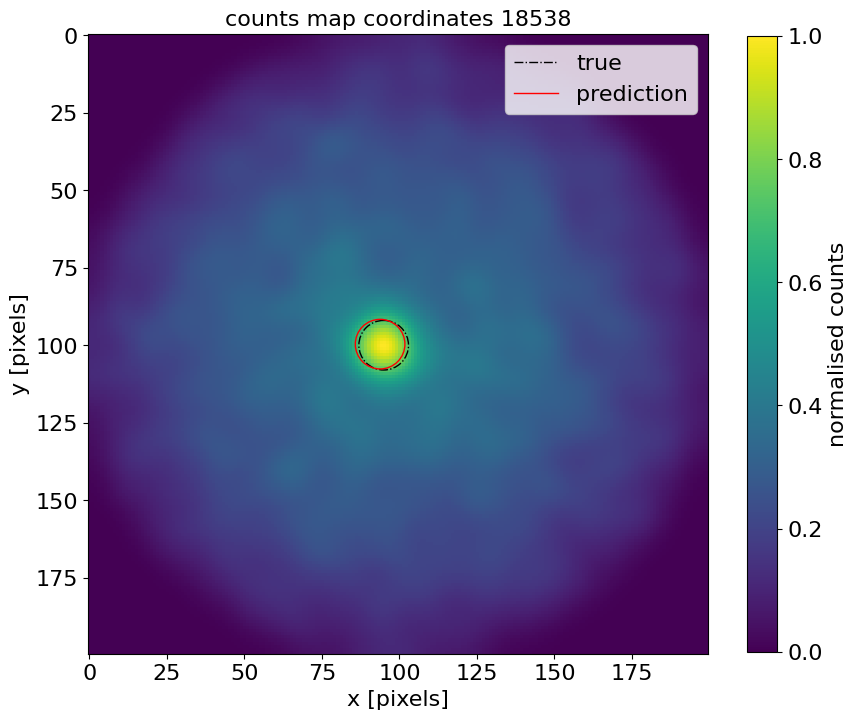

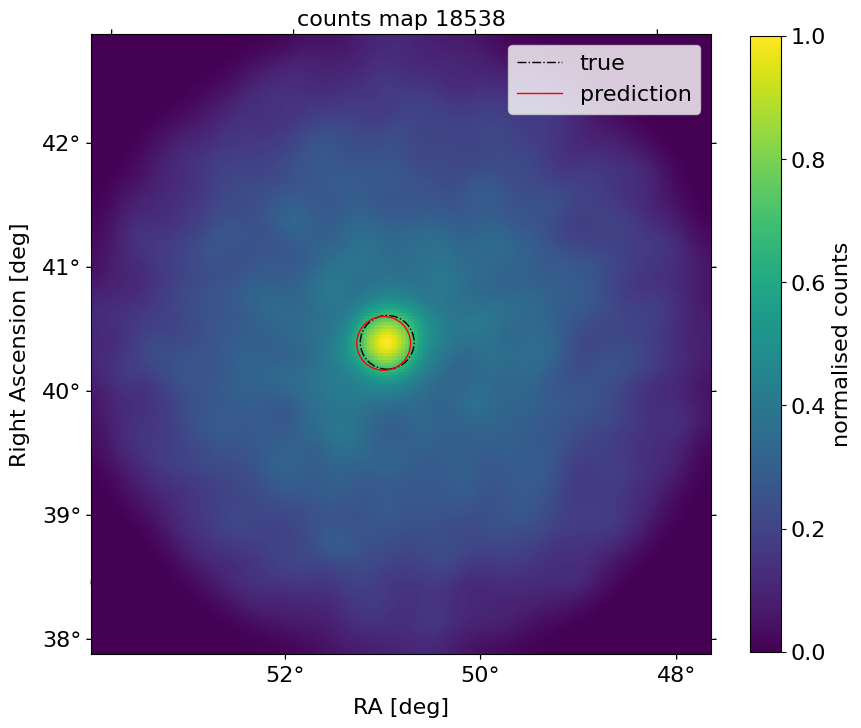

In [12]:
# PIX
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

img = ax.imshow(test_data[idx], vmin=0, vmax=1)
ax.add_patch(plt.Circle((true_pix), radius=radius_pix, edgecolor='k', facecolor='none', ls='-.'))
ax.add_patch(plt.Circle((pred_pix), radius=radius_pix, edgecolor='r', facecolor='none', ls='-'))
ax.set_ylabel('y [pixels]', fontsize=fs)
ax.set_xlabel('x [pixels]', fontsize=fs)
ax.set_title(f'counts map coordinates {seed}', fontsize=fs)
ax.legend(custom_lines[:2], ['true', 'prediction'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/regressor_{seed}_pix.png')
plt.show()

# SKY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)

img = ax.imshow(test_data[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.scatter(true_sky[0], true_sky[1], transform=ax.get_transform('icrs'), s=sz,
           edgecolor='k', facecolor='none', ls='-.')
ax.scatter(pred_sky[0], pred_sky[1], transform=ax.get_transform('icrs'), s=sz,
           edgecolor='r', facecolor='none', ls='-')
ax.set_ylabel('Right Ascension [deg]', fontsize=fs)
ax.set_xlabel('RA [deg]', fontsize=fs)
ax.set_title(f'counts map {seed}', fontsize=fs)
ax.legend(custom_lines[:2], ['true', 'prediction'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/regressor_{seed}_sky.png')
plt.show()

plt.show()

# Plot loss

In [13]:
loss = model.evaluate(test_data, test_labels, verbose=2)

125/125 - 6s - loss: 0.0178 - accuracy: 0.9617 - 6s/epoch - 48ms/step


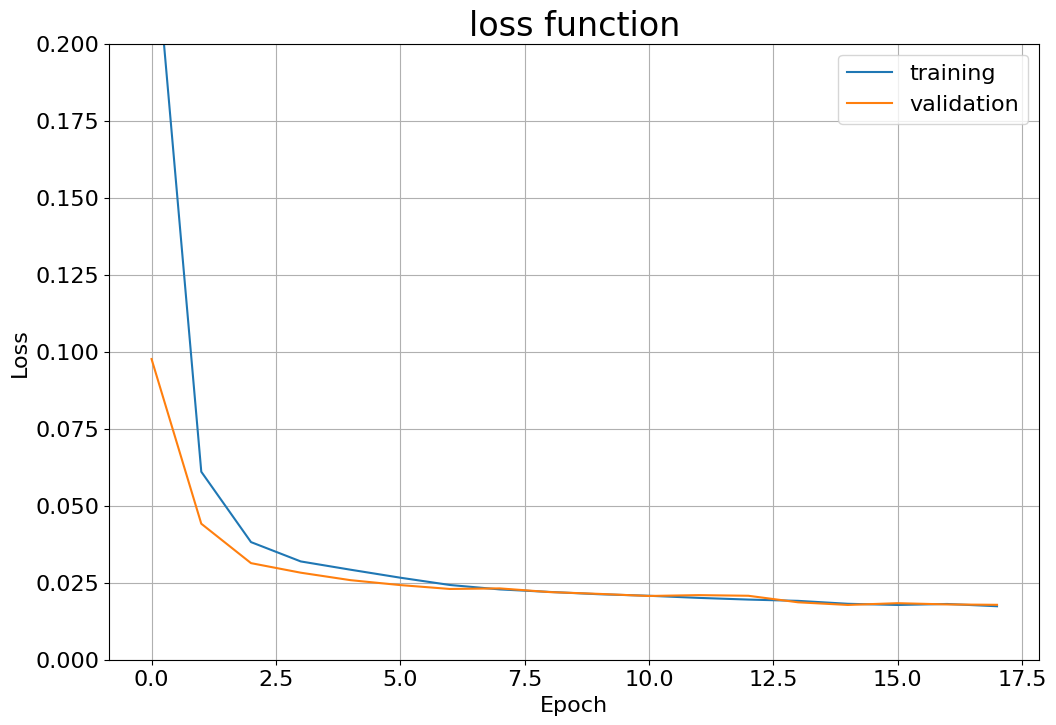

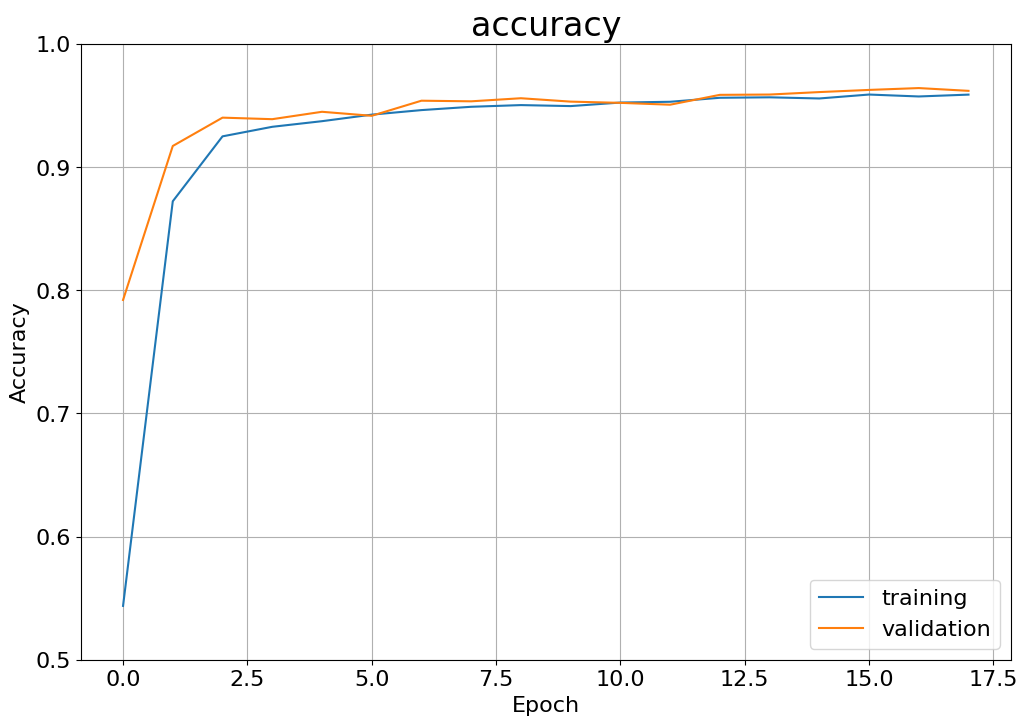

In [14]:
import matplotlib.pyplot as plt

history = np.load(f'/home/dipiano/astroAI/astroai/models/cnn_regressor/{savename}_history.npy', 
                  allow_pickle='TRUE').item()

# LOSS
fig, ax = plt.subplots(figsize=histsize)
ax.tick_params(axis='both', labelsize=fs)
ax.plot(history['loss'], label='training')
ax.plot(history['val_loss'], label = 'validation')
ax.set_xlabel('Epoch', fontsize=fs)
ax.set_ylabel('Loss', fontsize=fs)
ax.set_title('loss function', fontsize=fs*1.5)
ax.set_ylim([0.0,0.2])
ax.grid()
ax.legend(fontsize=fs)

plt.show()
fig.savefig(f'img/regressor_loss.png')

# ACCURACY
fig, ax = plt.subplots(figsize=histsize)
ax.tick_params(axis='both', labelsize=fs)
ax.plot(history['accuracy'], label='training')
ax.plot(history['val_accuracy'], label = 'validation')
ax.set_xlabel('Epoch', fontsize=fs)
ax.set_ylabel('Accuracy', fontsize=fs)
ax.set_title('accuracy', fontsize=fs*1.5)
ax.set_ylim([0.5,1])
ax.grid()
ax.legend(fontsize=fs)

plt.show()
fig.savefig(f'img/regressor_accuracy.png')

# Get separation error

In [15]:
from astroai.tools.utils import *
from astropy.coordinates import SkyCoord

# get true coordinates in SkyCoord
true = SkyCoord(ra=row['source_ra'].values[0], dec=row['source_dec'].values[0], unit='deg', frame='icrs')

# get errors
err = true.separation(sky)

print(f"TRUE: ({true.ra.deg}, {true.dec.deg})\n")
print(f"PREDICTION: ({sky.ra.deg}, {sky.dec.deg})\n")
print(f"ERROR: {err.deg}")

TRUE: (50.957358468504815, 40.43888270480629)

PREDICTION: (50.99513095486745, 40.43026854734565)

ERROR: 0.030013166372797388


# Get DS separation error

In [16]:
err = []
s = len(train_data)
for pred, label in zip(predictions, test_labels):
    s += 1 
    row = infodata[infodata['seed']==s]
    # WCS coordinates
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
                point_ref=point_ref, pixelsize=pixelsize)
    # simulated coordinates
    true_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
    true_pix = {'x': label[0], 'y': label[1]}
    # prediction coordinates
    sky = w.pixel_to_world(pred[0], pred[1])
    found_deg = {'ra': sky.ra.deg, 'dec': sky.dec.deg}
    # find separation in data
    true_sky = SkyCoord(ra=true_deg['ra'], dec=true_deg['dec'], unit='deg', frame='icrs')
    found_sky = SkyCoord(ra=found_deg['ra'], dec=found_deg['dec'], unit='deg', frame='icrs')
    err.append(true_sky.separation(found_sky))

err_noisy = [e.degree for e in err]
len(err_noisy)

4000

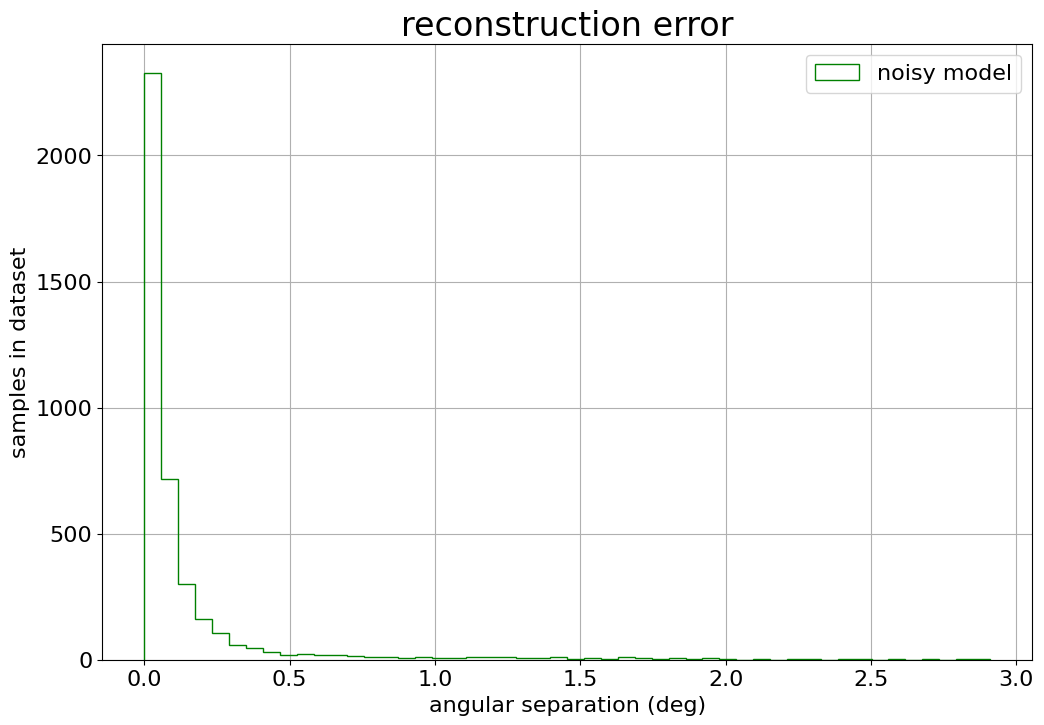

In [17]:
fig, ax = plt.subplots(figsize=histsize)
ax.tick_params(axis='both', labelsize=fs)

# cumulative counts hist
data = err_noisy
ax.set_title('reconstruction error', fontsize=fs*1.5)
ax.hist(data, 50, density=False, histtype='step', color='g', label=['noisy model'])
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('angular separation (deg)', fontsize=fs)
ax.grid()
ax.legend(fontsize=fs)

plt.show()
fig.savefig(f'img/regressor_loc_error_noisy.png')

# Gammapy comparison

In [18]:
gammafile = infotable.replace('.dat', '_gammapy.txt')
gammadata = pd.read_csv(gammafile, sep=' ', header=0).sort_values(by=['seed'])
gammadata.head()

,seed,loc_ra,loc_dec,counts_on,counts_off,excess,excess_err,sigma,correct_irf,selected_irf
0,8001,160.074066,5.495648,NaN,NaN,NaN,NaN,NaN,North_z20_S_0.5h_LST,/data01/homes/dipiano/caldb/data/cta/prod5/Pro...
1,8002,288.501191,10.680641,NaN,NaN,NaN,NaN,NaN,North_z20_N_0.5h_LST,/data01/homes/dipiano/caldb/data/cta/prod5/Pro...
2,8003,243.508483,80.010392,NaN,NaN,NaN,NaN,NaN,North_z20_N_0.5h_LST,/data01/homes/dipiano/caldb/data/cta/prod5/Pro...
3,8004,181.084998,73.805329,NaN,NaN,NaN,NaN,NaN,North_z20_N_0.5h_LST,/data01/homes/dipiano/caldb/data/cta/prod5/Pro...
4,8005,237.250146,-79.382836,NaN,NaN,NaN,NaN,NaN,North_z20_N_0.5h_LST,/data01/homes/dipiano/caldb/data/cta/prod5/Pro...


In [19]:
err = []
seeds = gammadata['seed']
for i, seed in enumerate(seeds):
    row = infodata[infodata['seed']==seed]
    grow = gammadata[gammadata['seed']==seed]
    # WCS coordinates
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
                point_ref=point_ref, pixelsize=pixelsize)
    # simulated coordinates
    true_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
    # found coordinates
    found_deg = {'ra': grow['loc_ra'].values[0], 'dec': grow['loc_dec'].values[0]}
    # find separation in data
    true_sky = SkyCoord(ra=true_deg['ra'], dec=true_deg['dec'], unit='deg', frame='icrs')
    found_sky = SkyCoord(ra=found_deg['ra'], dec=found_deg['dec'], unit='deg', frame='icrs')
    err.append(true_sky.separation(found_sky))
    
err_gamma = [e.degree for e in err]
len(err_noisy), len(err_gamma)

(4000, 2000)

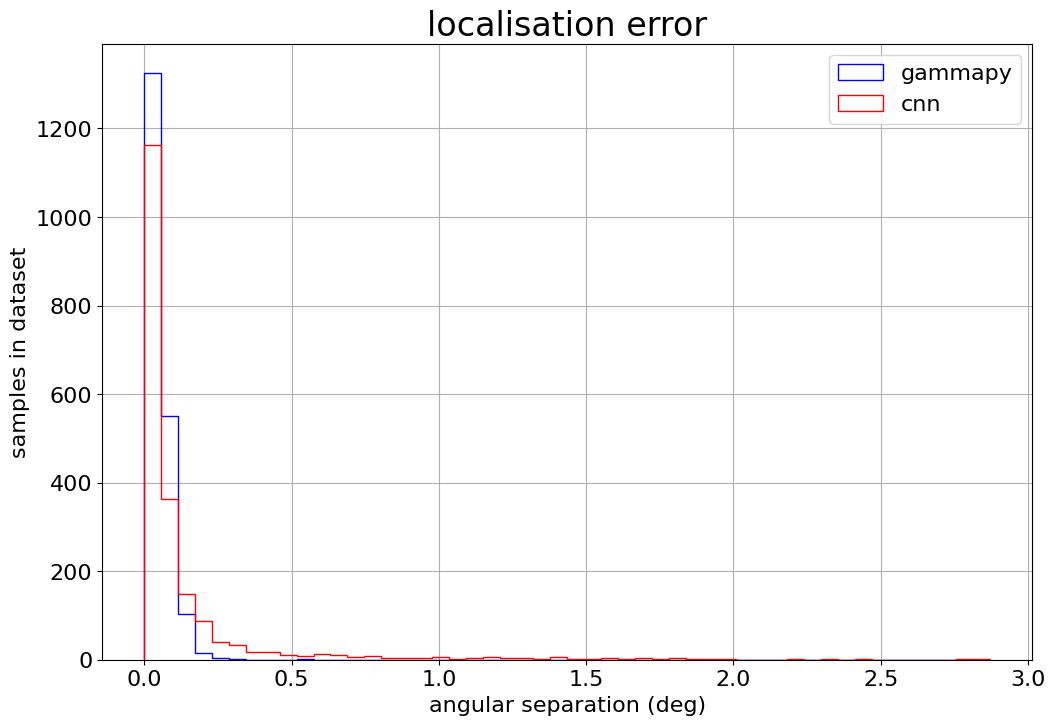

In [21]:
data = (err_noisy[2000:], err_gamma)

colors = ['red', 'blue']

fig, ax = plt.subplots(figsize=(12, 8))
ax.tick_params(axis='both', labelsize=fs)

# cumulative counts hist
ax.set_title('localisation error', fontsize=fs*1.5)
ax.hist(data, 50, density=False, histtype='step', color=colors, label=['cnn', 'gammapy'])
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('angular separation (deg)', fontsize=fs)
ax.grid()
ax.legend(fontsize=fs)

plt.show()
fig.savefig(f'img/regressor_loc_error_cnn_vs_gp.png')